## Self-Driving Car Engineer Nanodegree

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Set dependency

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os, sys 
sys.path.append('lib/')
from vtcv.dataset import visualize_dataset as vd
from functools import partial
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import imageio
imageio.plugins.ffmpeg.download()

##### Functions from previous step

In [2]:
def undistort_img(img, camparam, dpRslt=False):
    '''
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    undist = undist[y:y+h, x:x+w]
    '''
    undist = cv2.undistort(img, camparam['mtx'], camparam['dist'], None, camparam['mtx'])
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(undist)
        
    return undist

def hls_denoised_lanefilter(img, dpRslt=False) :
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    if dpRslt :
        fig, axs = plt.subplots(1,4, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.01)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]  
    
    if dpRslt :
        axs[0].set_title("l_channel")
        axs[0].imshow(l_channel,cmap='gray')
    
    #filter_out = cv2.bilateralFilter(filter_out,50,50,50)
    #filter_out = cv2.fastNlMeansDenoisingColored(filter_out,None,10,10,7,21)    
    s_channel=cv2.medianBlur(s_channel,11)
    
    if dpRslt :
        axs[1].set_title("s_channel  ")
        axs[1].imshow(s_channel,cmap='gray')

    l_s_merge = cv2.addWeighted(l_channel,0.5,s_channel,0.5,0)
    l_s_merge = cv2.dilate(l_s_merge, (10,10), iterations=5)
    if dpRslt :
        axs[2].set_title("l_channel + s_channel ")
        axs[2].imshow(l_s_merge,cmap='gray')
    
    #filter_out = cv2.bilateralFilter(filter_out,50,50,50)
    median_blur_l_s_merge=cv2.medianBlur(l_s_merge,11)
    #filter_out = cv2.fastNlMeansDenoisingColored(filter_out,None,10,10,7,21)

    if dpRslt :
        axs[3].set_title("apply median blur")
        axs[3].imshow(median_blur_l_s_merge,cmap='gray')
    
    merged_out = cv2.addWeighted(l_s_merge,0.7,median_blur_l_s_merge,0.6,0)
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]
        axs[0].imshow(img)
        axs[1].imshow(merged_out,cmap='gray')
        
    # Return the binary image
    return merged_out 

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), dilate=0, dpRslt=False):
    # Convert to grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    #abs_sobel = cv2.GaussianBlur(abs_sobel,(7,7),0) # thresh = (0.5,1.2) , (0.3,1.3)        
    abs_sobel[(abs_sobel < thresh[0]) | (abs_sobel > thresh[1])] = 0
    
    if dilate > 0 :
        abs_sobel = cv2.dilate(abs_sobel, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(abs_sobel,cmap='gray')
        
    return abs_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dilate=0, dpRslt=False):
    # Convert to grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    #gradmag = cv2.GaussianBlur(gradmag,(7,7),0) # thresh = (0.5,1.2) , (0.3,1.3)
    gradmag[(gradmag < mag_thresh[0]) | (gradmag > mag_thresh[1])] = 0
        
    # Create a binary image of ones where threshold is met, zeros otherwise
    if dilate > 0 :    
        gradmag = cv2.dilate(gradmag, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(gradmag,cmap='gray')
        
    return gradmag

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), dilate=0, dpRslt=False):
    # Grayscale
    if len(img.shape) > 2 :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else :
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
    #print ("absgraddir max : ", np.max(absgraddir))
    #print ("absgraddir min : ", np.min(absgraddir))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255 
    #absgraddir[(absgraddir < thresh[0]) | (absgraddir > thresh[1])] = 0
    if dilate > 0 :    
        binary_output = cv2.dilate(binary_output, (10,10), iterations=dilate)
        
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        axs[1].imshow(binary_output,cmap='gray')
        
    # Return the binary image
    return binary_output

# Apply each of the thresholding functions
def frame_binaryzation(img,dspRslt=False, thresh=(200,255), dspDebug=False) :
    if dspDebug :
        fig, axs = plt.subplots(2,5, figsize=(16, 5))
        fig.subplots_adjust(hspace = .001, wspace=.01)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]  
    
    ## Bilateral_HLS 
    bilateral_hls = hls_denoised_lanefilter(img,dpRslt=False) 
    if dspDebug :
        axs[0].set_title("Bilateral HLS ")
        axs[0].imshow(bilateral_hls,cmap='gray')
    
    # sobel x on RGB + sobel x on HLS
    sobx = abs_sobel_thresh(bilateral_hls, orient='x', thresh=(0,255), dilate=3, dpRslt=False )
    if dspDebug :
        axs[1].set_title("abs_sobel_thresh x")
        axs[1].imshow(sobx,cmap='gray')

    soby = abs_sobel_thresh(bilateral_hls, orient='y', thresh=(0,255), dilate=3, dpRslt=False )
    if dspDebug :
        axs[2].set_title("abs_sobel_thresh y")
        axs[2].imshow(soby,cmap='gray')

    magth = mag_thresh(bilateral_hls, mag_thresh=(0, 255), dilate=2, dpRslt=False )
    if dspDebug :
        axs[3].set_title("mag_thresh")
        axs[3].imshow(magth,cmap='gray')

    #gblr = cv2.GaussianBlur(bilateral_hls,(21,21),0) # thresh = (0.5,1.2) , (0.3,1.3)
    dirth = dir_threshold(bilateral_hls, sobel_kernel=15, thresh=(0.3, 1.3), dilate=2, dpRslt=False)
    if dspDebug :
        axs[4].set_title("dir_threshold")
        axs[4].imshow(magth,cmap='gray')
    
    bilateral_hls= bilateral_hls.astype(np.float64)
    magth = magth.astype(np.float64)
    sobel_result = cv2.addWeighted(sobx, 0.5, soby, 0.5, 0)
    if dspDebug :
        axs[5].set_title("sobel_result")
        axs[5].imshow(sobel_result,cmap='gray')

    sob_grad_result = cv2.addWeighted(sobel_result, 0.3, magth, 0.7, 0)
    if dspDebug :
        axs[6].set_title("sob_grad_result")
        axs[6].imshow(sob_grad_result,cmap='gray')
    
    hls_drith_mask = cv2.addWeighted(bilateral_hls, 0.9, dirth, 0.3, 0)
    if dspDebug :
        axs[7].set_title("hls_dirth_mask")
        axs[7].imshow(hls_drith_mask,cmap='gray')

    lane_recog_mask= cv2.addWeighted(sob_grad_result, 0.7, hls_drith_mask, 0.3, 0)
    if dspDebug :
        axs[8].set_title("lane_recog_mask")
        axs[8].imshow(lane_recog_mask,cmap='gray')
    
    final_lane_mask= cv2.addWeighted(bilateral_hls, 0.3, lane_recog_mask, 0.7, 0)
    if dspDebug :
        axs[9].set_title("final_lane_mask")
        axs[9].imshow(final_lane_mask,cmap='gray')

    final_lane_mask = cv2.erode(final_lane_mask, (5,5), iterations=2)
    #final_lane_mask = cv2.GaussianBlur(final_lane_mask,(5,5),0)   
    binary_output =  np.zeros_like(final_lane_mask)
    binary_output[(final_lane_mask >= thresh[0]) & (final_lane_mask <= thresh[1])] = 255 

    #lx = abs_sobel_thresh(binary_output, orient='x', thresh=(0,255), dilate=2, dpRslt=False )
    #ly = abs_sobel_thresh(binary_output, orient='y', thresh=(0,255), dilate=2, dpRslt=False )
    #binary_output[(lx > 100) & (ly>100) & (binary_output>200) ] = 255

    #colored_binary = cv2.merge([binary_output,binary_output,binary_output])
    #output = colored_binary
    #output = cv2.Canny(colored_binary,50,150)

    output = binary_output

    if dspRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.003)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        if len(img.shape) > 2 :
            axs[0].imshow(img)
        else :
            axs[0].imshow(img,cmap='gray')
        #axs[1].imshow(output)#,cmap='gray')
        axs[1].imshow(output,cmap='gray')
        
    return output

### 4. Birds-eye view
* Apply a perspective transform to rectify binary image ("birds-eye view").

In [3]:
with open('camparam.p', 'rb') as handle:
    camparam = pickle.load(handle)

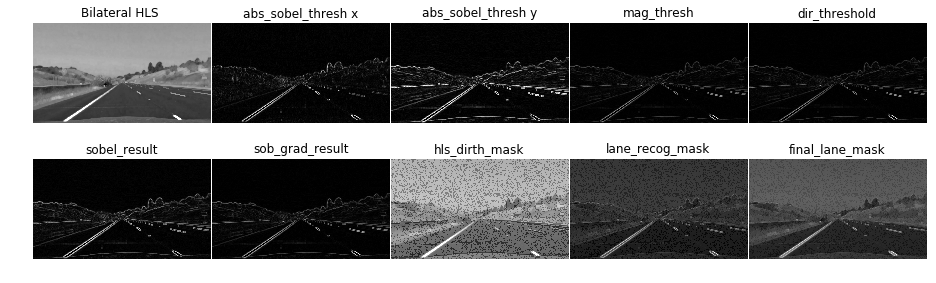

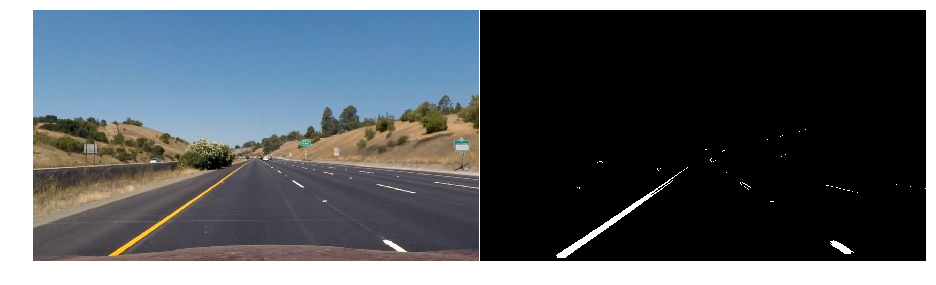

In [4]:
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = undistort_img(img, camparam, dpRslt=False )
bin_img = frame_binaryzation(img,dspRslt=True,thresh=(120,255),dspDebug=True)

### Perspective Transformation

#### pick points from the source image

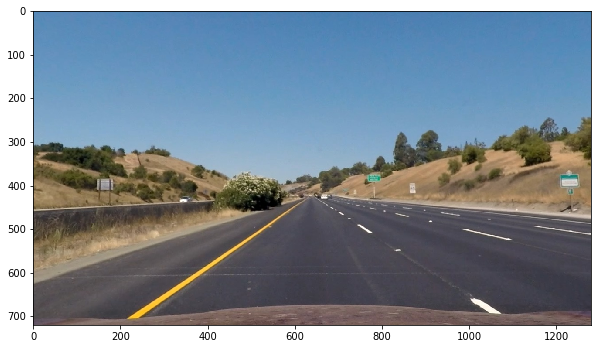

In [5]:
#%matplotlib qt
fig = plt.figure(figsize=(10,8))
plt.imshow(img)

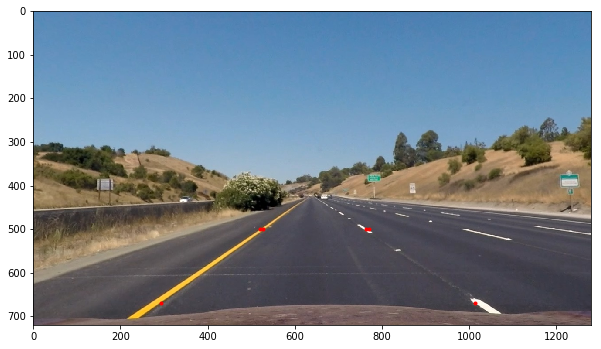

In [6]:
#%matplotlib qt
%matplotlib inline
fig = plt.figure(figsize=(10,8))
plt.imshow(img)
plt.plot(292,670,'.',color='red')
plt.plot(1013,670,'.',color='red')
plt.plot(527,500,'.',color='red')
plt.plot(764,500,'.',color='red')
plt.plot(521,500,'.',color='red')
plt.plot(769,500,'.',color='red')

In [7]:
def warp(img, dpRslt=False) :
    img_size = (img.shape[1],img.shape[0])
   
    src_points = np.float32([[292,670],
                             [1013,670],
                             [527,500],
                             [765,500]])
    
    dst_points = np.float32([[350,720],
                             [800,720],
                             [350,450],
                             [800,450]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(warped)
        
    # Return the binary image
    return warped

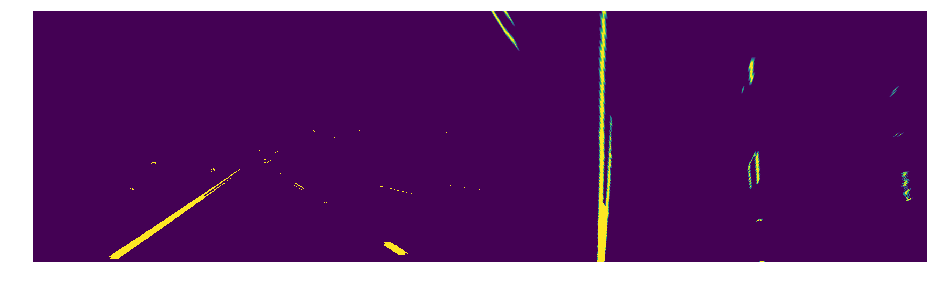

In [8]:
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = undistort_img(img, camparam, dpRslt=False )
#bin_img = frame_binaryzation(img,dspRslt=False)
bin_img = frame_binaryzation(img,dspRslt=False,thresh=(120,255),dspDebug=False)
birdseye = warp(bin_img,dpRslt=True)

# sample : 8  sampling_rate : 1.0  # of data : 8
size =  (256, 256, 3)


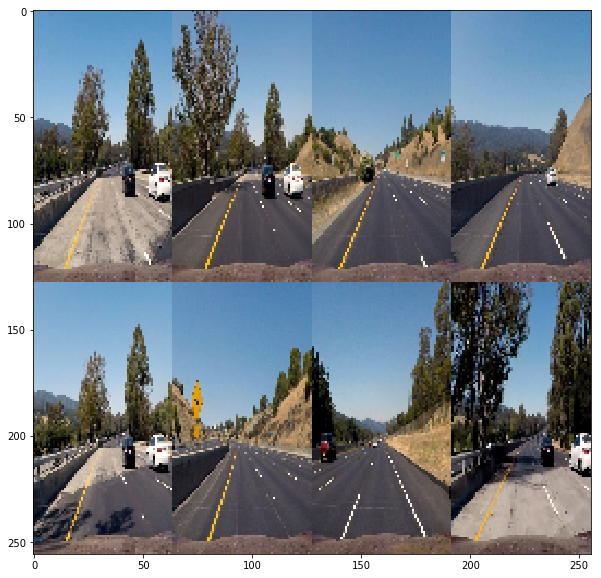

In [9]:
# Check camera calibration images
test_imgs = vd.show_sampled_dataset_from_dir('test_images',filepat='*.jpg',sampling_rate=1.0)

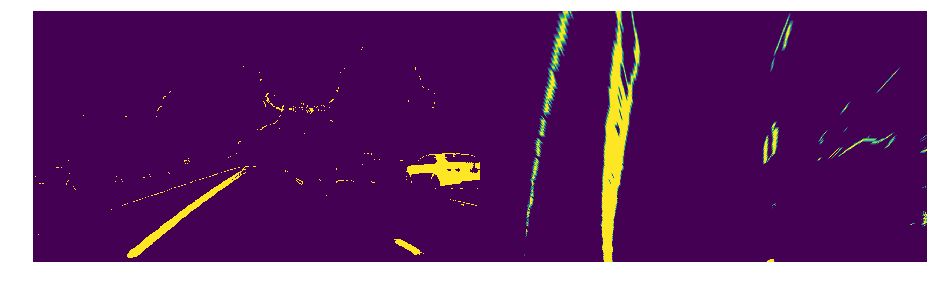

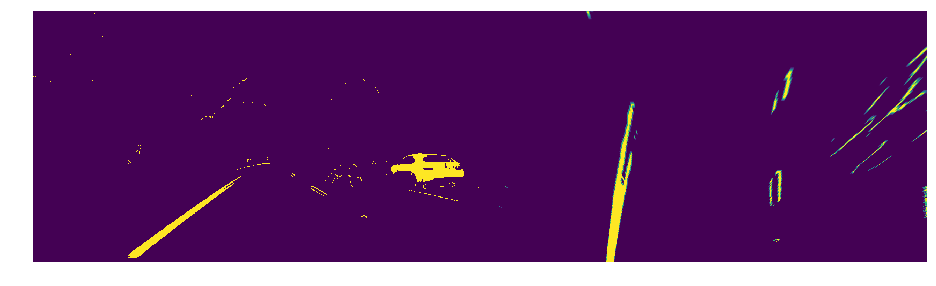

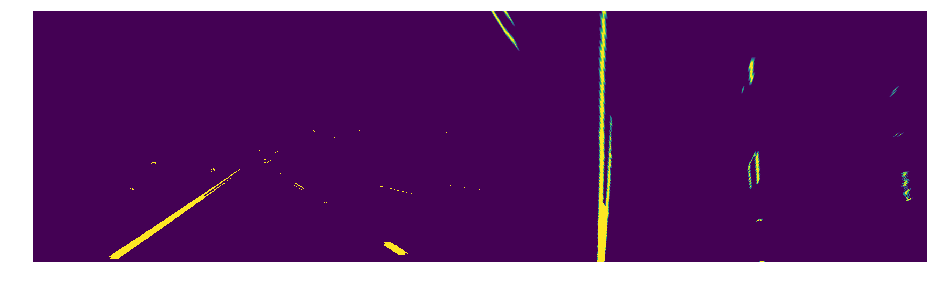

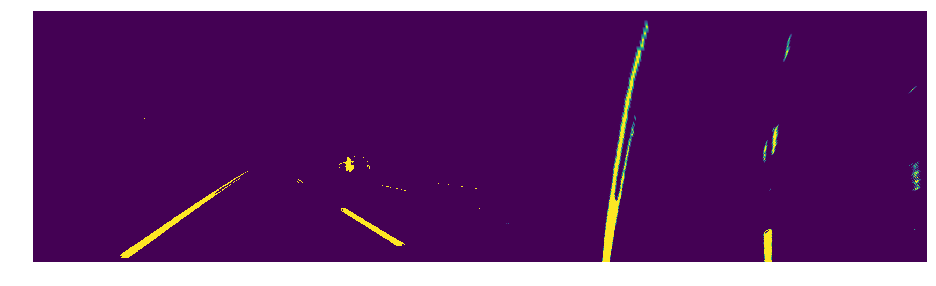

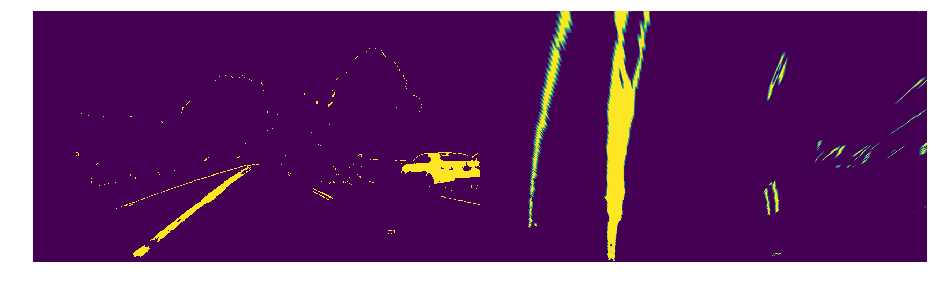

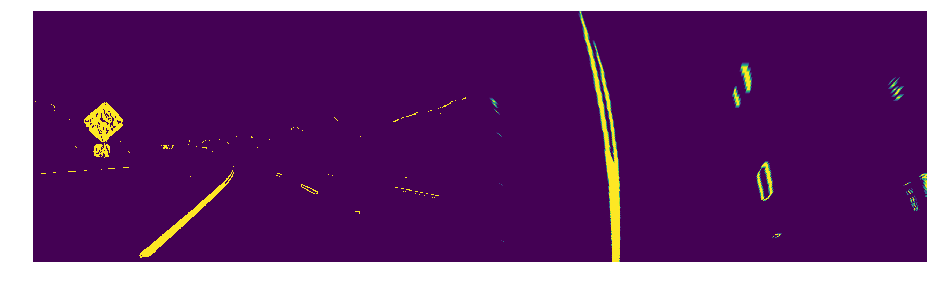

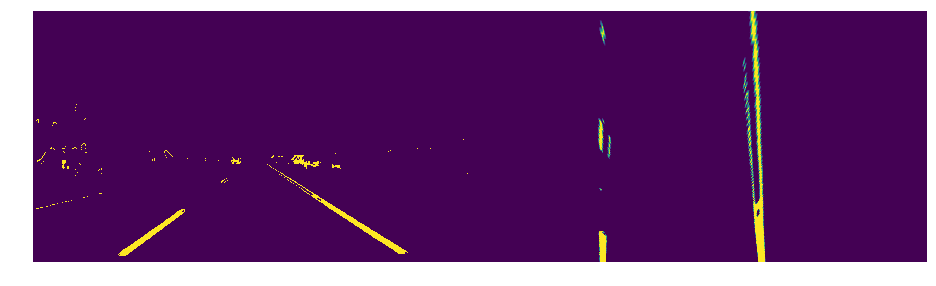

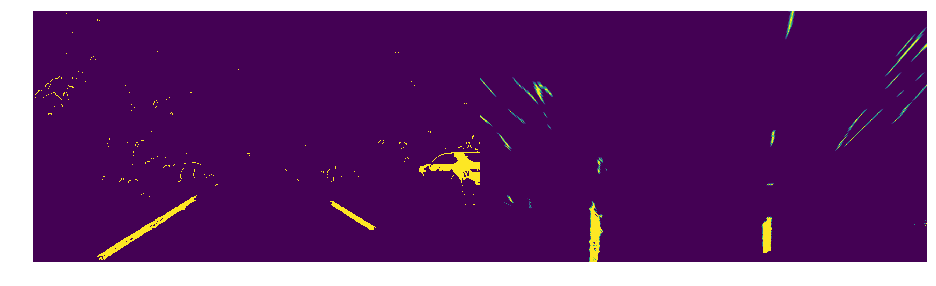

In [10]:
for img_path in test_imgs :
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = undistort_img(img, camparam, dpRslt=False )
    #bin_img = frame_binaryzation(img,dspRslt=False)
    bin_img = frame_binaryzation(img,dspRslt=False,thresh=(120,255),dspDebug=False)
    birdseye = warp(bin_img,dpRslt=True)

### Apply the pipeline to video

In [11]:
def lane_pipeline(img,camparam,dpRslt=False) :
    img = undistort_img(img, camparam, dpRslt=False )
    #bin_img = frame_binaryzation(img,dspRslt=False)
    bin_img = frame_binaryzation(img,dspRslt=False,thresh=(120,255),dspDebug=False)
    birdseye = (warp(bin_img,dpRslt=False)).astype(int)
    #birdseye = birdseye * 255 
    col_binary = cv2.merge([birdseye,birdseye,birdseye])
    
    if dpRslt :
        fig, axs = plt.subplots(1,2, figsize=(16, 11))
        fig.subplots_adjust(hspace = .1, wspace=.001)
        axs = axs.ravel()
        axs_set = [a.axis('off') for a in axs]    
        axs[0].imshow(img)
        axs[1].imshow(col_binary,cmap='gray')
    
    return col_binary

(720, 1280, 3)

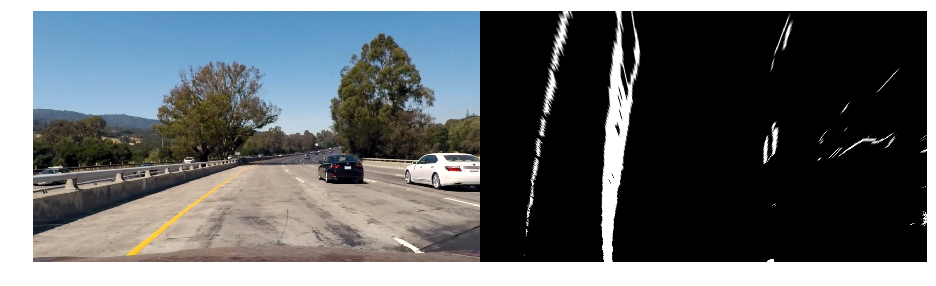

In [12]:
img = cv2.imread(test_imgs[0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
output = lane_pipeline(img,camparam,dpRslt=True)
output.shape

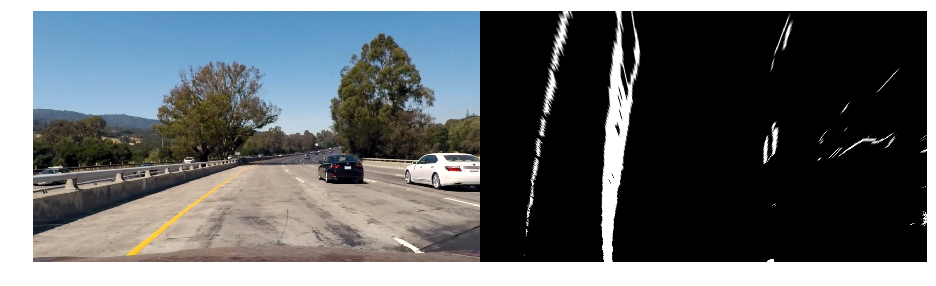

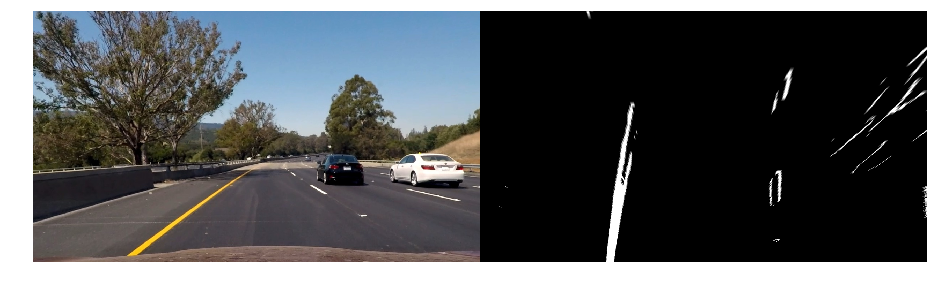

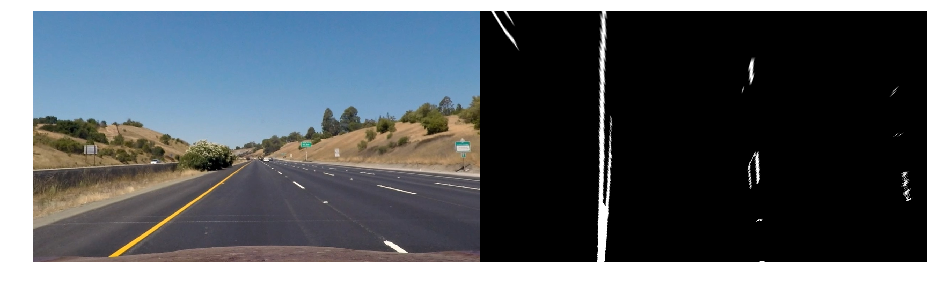

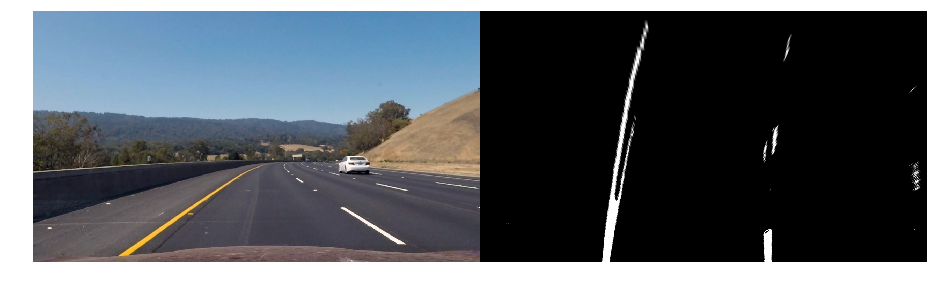

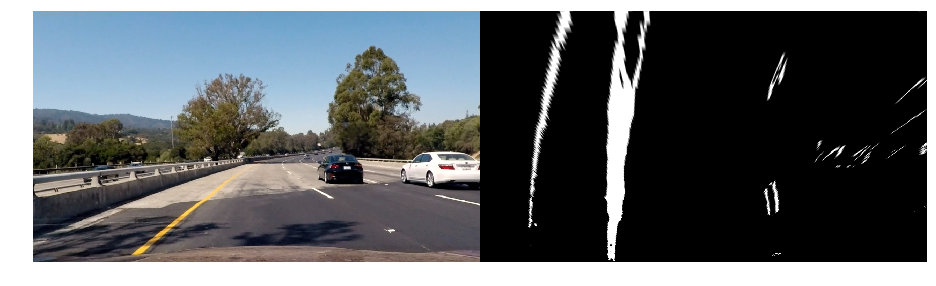

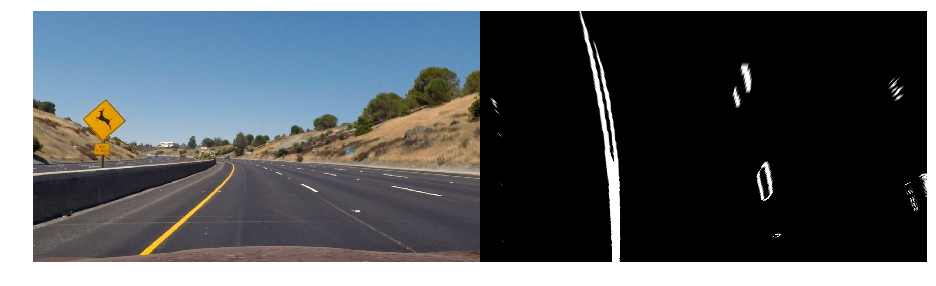

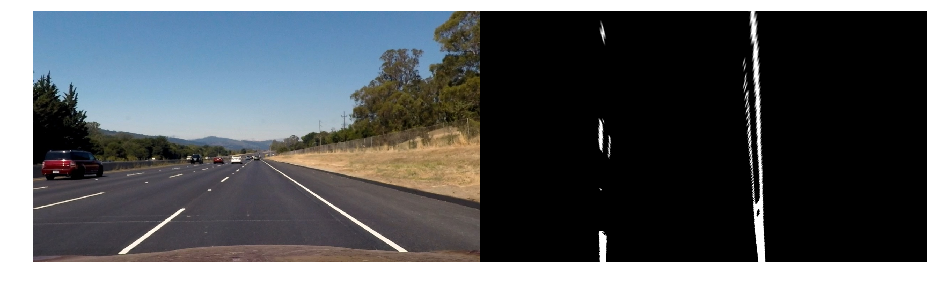

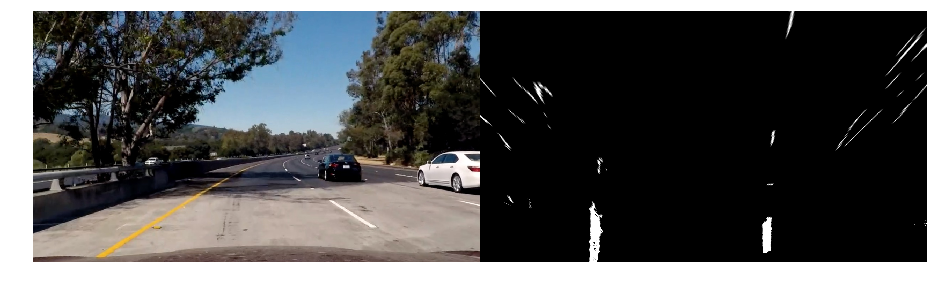

In [13]:
for img_path in test_imgs :
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    col_binary = lane_pipeline(img,camparam,dpRslt=True)

In [14]:
## Input Video
project_video = 'project_video.mp4'
cahllenge_video = 'challenge_video.mp4'
harder_cahllenge_video = 'harder_challenge_video.mp4'

## Ouput
rectified_project_video = 'temp/rectified_project_video.mp4'
rectified_cahllenge_video = 'temp/rectified_challenge_video.mp4'
rectified_harder_cahllenge_video = 'temp/rectified_harder_challenge_video.mp4'

In [17]:
## Load camera calibration parameters
with open('camparam.p', 'rb') as handle:
    camparam_loaded = pickle.load(handle)

## Process project_video
clip = VideoFileClip(project_video)#.subclip(0,3)
rectified_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded ,dpRslt=False))
%time rectified_clip.write_videofile(rectified_project_video, audio=False)

[MoviePy] >>>> Building video temp/rectified_project_video.mp4
[MoviePy] Writing video temp/rectified_project_video.mp4


100%|█████████▉| 1260/1261 [09:59<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/rectified_project_video.mp4 

CPU times: user 1h 58min 7s, sys: 22min 47s, total: 2h 20min 55s
Wall time: 9min 59s


In [18]:
## Process cahllenge_video
clip = VideoFileClip(cahllenge_video)
rectified_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded ,dpRslt=False))
%time rectified_clip.write_videofile(rectified_cahllenge_video, audio=False)

[MoviePy] >>>> Building video temp/rectified_challenge_video.mp4
[MoviePy] Writing video temp/rectified_challenge_video.mp4


100%|██████████| 485/485 [03:52<00:00,  2.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/rectified_challenge_video.mp4 

CPU times: user 46min, sys: 8min 44s, total: 54min 45s
Wall time: 3min 52s


In [19]:
## Process harder_cahllenge_video
clip = VideoFileClip(harder_cahllenge_video)
rectified_clip = clip.fl_image(partial(lane_pipeline, camparam=camparam_loaded ,dpRslt=False))
%time rectified_clip.write_videofile(rectified_harder_cahllenge_video, audio=False)

[MoviePy] >>>> Building video temp/rectified_harder_challenge_video.mp4
[MoviePy] Writing video temp/rectified_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [09:54<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: temp/rectified_harder_challenge_video.mp4 

CPU times: user 1h 56min 13s, sys: 22min 7s, total: 2h 18min 21s
Wall time: 9min 55s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video><br/>
<video width="960" height="540" controls>
  <source src="{1}">
</video><br/>
<video width="960" height="540" controls>
  <source src="{2}">
</video>
""".format(rectified_project_video,rectified_cahllenge_video,rectified_harder_cahllenge_video))